In [1]:
import os
os.chdir("..")

from agents.utils import create_bins, discretize_observation
from scipy import stats
from ast import literal_eval
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
import json
import ast

### Permutation test: Early vs Late MAPE (data: 20 run x 35 trials)

In [2]:
def run_glm(y, x):
    regressors = x
    regressors = sm.add_constant(regressors)
    model = sm.OLS(y, regressors).fit()

    # test multiple regression;
    alpha = model.params[0]
    beta = model.params[1]
    return alpha, beta

def mean_absolute_percentage_error(log_data):
    all_mape = []
    for i in range(len(log_data)):
        if i == 0:
            hrf = np.array(literal_eval(log_data[0]["hrf"]))
            reward = np.array(literal_eval(log_data[-1]["reward"]))
            n_trials = len(log_data)
        else:
            q_table = np.array(literal_eval(log_data[i]["q_table"])).reshape(10, 10)
            action = np.array(literal_eval(log_data[i]["current action"]))
            fmridata = np.array(literal_eval(log_data[i]["fmri_data"]))

            # clip action max values to avoid going out of bounds;
            if action[0] == 1.0:
                action[0] = 0.9

            if action[1] == 1.0:
                action[1] = 0.9

            q_val = q_table[int(action[0]*10), int(action[1]*10)]
            #alpha, beta = run_glm(hrf, fmridata)
            #reward = (beta / alpha) * 100

            all_mape.append( abs(( reward[i - 1] - q_val) / reward[i - 1] ) )

    return all_mape

data_path = "./data"
mape = []
steps = 35

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Construct the paths for data_1/log and data_2/log
        data_1_log_path = os.path.join(folder_path, "data_1/log", "log.json")
        data_2_log_path = os.path.join(folder_path, "data_2/log", "log.json")

        # Read log.json from data_1
        if os.path.exists(data_1_log_path):
            with open(data_1_log_path, "r") as file_1:
                log_data_1 = json.load(file_1)
                score = mean_absolute_percentage_error(log_data_1)
                if len(mape) == 0:
                    mape = score[:steps]
                else:
                    mape = np.vstack((mape, score[:steps]))

        # Read log.json from data_2
        if os.path.exists(data_2_log_path):
            with open(data_2_log_path, "r") as file_2:
                log_data_2 = json.load(file_2)
                score = mean_absolute_percentage_error(log_data_2)
                if len(mape) == 0:
                    mape = score[:steps]
                else:
                    mape = np.vstack((mape, score[:steps]))

In [3]:
def permutation_test_mape_trend(mape_data, n_permutations=10000, num_edge_trials=5):
    """Minimal permutation test for MAPE trend, returns DataFrame and plot figure."""

    if not isinstance(mape_data, np.ndarray) or mape_data.ndim != 2:
        raise ValueError("mape_data must be a 2D NumPy array.")

    n_runs, n_trials = mape_data.shape

    if num_edge_trials <= 0 or num_edge_trials * 2 > n_trials:
        raise ValueError(f"num_edge_trials ({num_edge_trials}) invalid for n_trials ({n_trials}).")

    mean_early_observed = np.nanmean(mape_data[:, :num_edge_trials])
    mean_late_observed = np.nanmean(mape_data[:, -num_edge_trials:])
    observed_diff = mean_late_observed - mean_early_observed

    if np.isnan(observed_diff):
         raise ValueError("Observed difference is NaN. Check input data.")

    permutation_diffs = np.zeros(n_permutations)
    for i in range(n_permutations):
        shuffled_mape = np.array([np.random.permutation(run) for run in mape_data])
        mean_shuffled_early = np.nanmean(shuffled_mape[:, :num_edge_trials])
        mean_shuffled_late = np.nanmean(shuffled_mape[:, -num_edge_trials:])
        permutation_diffs[i] = mean_shuffled_late - mean_shuffled_early

    valid_perm_diffs = permutation_diffs[~np.isnan(permutation_diffs)]
    num_valid_perms = len(valid_perm_diffs)

    if num_valid_perms < n_permutations:
         warnings.warn(f"Removed {n_permutations - num_valid_perms} NaN results from permutations.", UserWarning)
         if num_valid_perms == 0:
              raise ValueError("All permutation statistics resulted in NaN.")

    p_value = np.mean(valid_perm_diffs <= observed_diff)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(valid_perm_diffs, bins=50, alpha=0.7, label='Permutation Differences')
    ax.axvline(observed_diff, color='red', linestyle='dashed', linewidth=2,
               label=f'Observed Diff ({observed_diff:.3f})')
    ax.set_xlabel("Difference (Mean Late MAPE - Mean Early MAPE)")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Permutation Test Distribution ({num_valid_perms} Permutations)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    fig.tight_layout()

    results_data = {
        "Metric": ["Mean Early MAPE", "Mean Late MAPE", "Observed Difference (Late - Early)", "P-value (one-sided)", "Num Valid Permutations"],
        "Value": [mean_early_observed, mean_late_observed, observed_diff, p_value, num_valid_perms]
    }
    results_df = pd.DataFrame(results_data)
    results_df['Value'] = results_df['Value'].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)

    return results_df, fig




--- Testing with Empirical MAPE Data ---

Permutation Test Results:
                            Metric      Value
                   Mean Early MAPE     0.3989
                    Mean Late MAPE     0.1685
Observed Difference (Late - Early)    -0.2304
               P-value (one-sided)     0.0000
            Num Valid Permutations 10000.0000

Displaying permutation distribution plot...


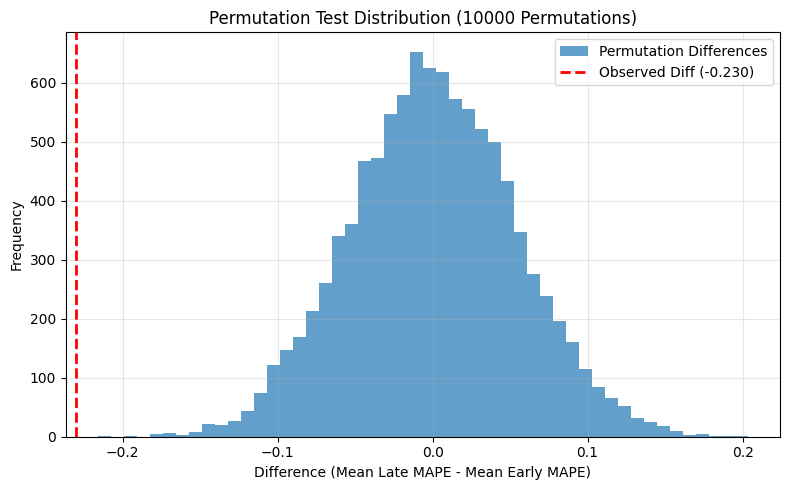

In [4]:
if mape is not None:
    print("\n--- Testing with Empirical MAPE Data ---")
    try:
        # Call the function with your actual 'mape' variable
        results_df_empirical, fig_empirical = permutation_test_mape_trend(
            mape, 
            n_permutations=10000, # Use a suitable number of permutations
            num_edge_trials=5      # Use 5 trials at each edge
        )
        
        print("\nPermutation Test Results:")
        print(results_df_empirical.to_string(index=False)) # Print DataFrame summary

        # Display the plot generated by the function
        print("\nDisplaying permutation distribution plot...")
        plt.show() 

    except ValueError as e:
        print(f"\nError during permutation test: {e}")
    except Exception as e:
        print(f"\nAn unexpected error occurred during the test: {e}")
else:
    print("\nSkipping permutation test because 'mape' data was not loaded/defined correctly.")

### Additional images

- Distribution of final preferred actions across all runs
- Q-values for the final Q-table across all runs
- Mean contrast/frequency position for all trials, across all runs

Starting data extraction...
Data extraction finished. Processed 20 Q-tables and 20 action sequences.

Analysis complete. Displaying plots...


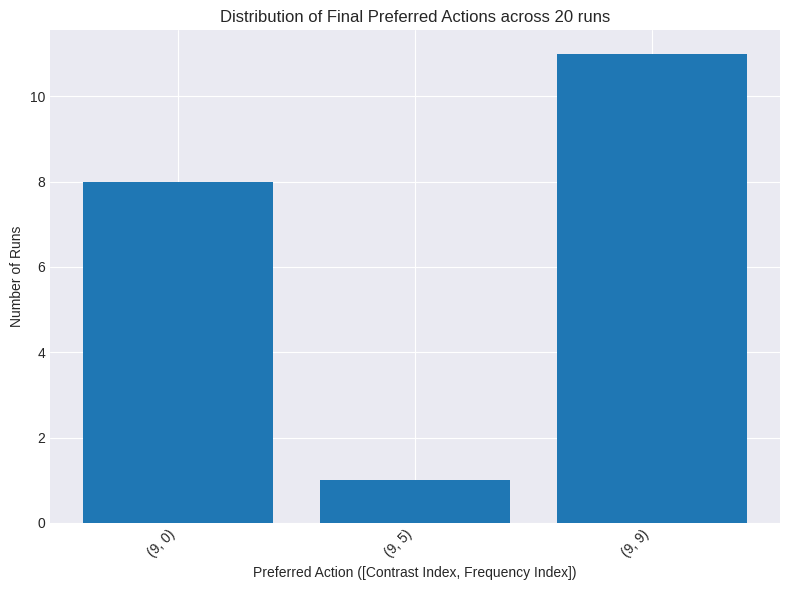

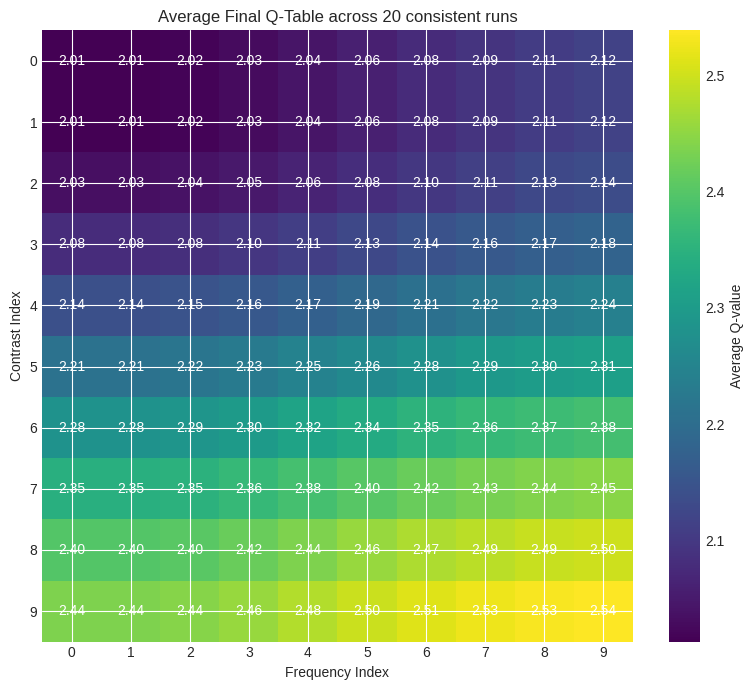

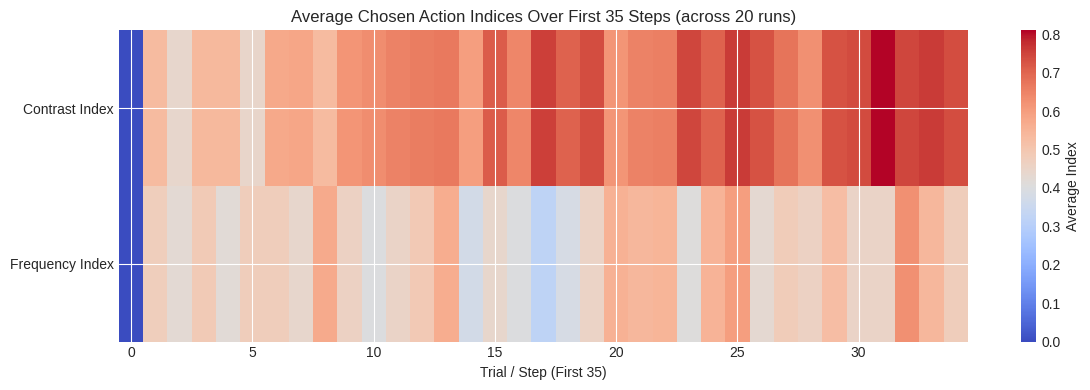

In [6]:
# --- Configuration ---
DATA_DIR = "./data"
NUM_SUBJECTS = 10
RUN_FOLDERS = ["data_1", "data_2"]
LOG_SUBFOLDER = "log"
SUBJECT_PREFIX = "sub-"
MAX_STEPS_PLOT = 35

# --- Data Storage ---
all_rewards = []
all_convergences = []
all_final_q_tables = []
all_preferred_actions = []
all_action_sequences = []

print("Starting data extraction...")
for i in range(1, NUM_SUBJECTS + 1):
    subject_id = f"{SUBJECT_PREFIX}{i:03d}"
    subject_path = os.path.join(DATA_DIR, subject_id)

    if not os.path.isdir(subject_path):
        continue

    for run_folder in RUN_FOLDERS:
        run_path = os.path.join(subject_path, run_folder)
        log_file_path = os.path.join(run_path, LOG_SUBFOLDER, "log.json")

        if not os.path.isfile(log_file_path):
            continue

        try:
            with open(log_file_path, 'r') as f:
                log_data = json.load(f)

                if not log_data:
                    continue

                last_entry = log_data[-1]
                current_run_actions = []

                for trial_data in log_data:
                    if 'last action' in trial_data:
                        try:
                            action_str = trial_data['last action']
                            if isinstance(action_str, str) and action_str.strip():
                                parsed_action = json.loads(action_str)
                                if isinstance(parsed_action, (list, tuple)) and len(parsed_action) == 2:
                                    try:
                                        action_pair = [float(parsed_action[0]), float(parsed_action[1])]
                                        current_run_actions.append(action_pair)
                                    except (ValueError, TypeError):
                                         # print(f"Warning: Non-numeric values in parsed 'last action' in {log_file_path}. Data: {parsed_action}") # Keep essential warnings if desired
                                         current_run_actions.append([np.nan, np.nan])
                                else:
                                    current_run_actions.append([np.nan, np.nan])
                            else:
                                current_run_actions.append([np.nan, np.nan])
                        except (json.JSONDecodeError, TypeError) as e:
                            print(f"Warning: Could not parse 'last action' data in {log_file_path}. Error: {e}. Data: {trial_data.get('last action', 'N/A')}")
                            current_run_actions.append([np.nan, np.nan])
                    else:
                        current_run_actions.append([np.nan, np.nan])

                if current_run_actions:
                     all_action_sequences.append(current_run_actions)

                if 'reward' in last_entry:
                    try:
                        reward_ts = np.array(json.loads(last_entry['reward']))
                        if reward_ts.ndim == 1 and len(reward_ts) > 0:
                            all_rewards.append(reward_ts)
                    except (json.JSONDecodeError, TypeError, ValueError) as e:
                        print(f"Warning: Could not parse reward data in {log_file_path}. Error: {e}.")

                if 'convergence' in last_entry:
                    try:
                        convergence_ts = np.array(json.loads(last_entry['convergence']))
                        if convergence_ts.ndim == 1 and len(convergence_ts) > 0:
                            all_convergences.append(convergence_ts)
                    except (json.JSONDecodeError, TypeError, ValueError) as e:
                        print(f"Warning: Could not parse convergence data in {log_file_path}. Error: {e}.")

                if 'q_table' in last_entry:
                     try:
                        q_table = np.array(json.loads(last_entry['q_table']))
                        if q_table.ndim == 2:
                            all_final_q_tables.append(q_table)
                            if np.any(~np.isnan(q_table)):
                                preferred_action_idx = np.unravel_index(np.nanargmax(q_table), q_table.shape)
                                all_preferred_actions.append(tuple(preferred_action_idx))
                            else:
                                all_preferred_actions.append((np.nan, np.nan))
                        else:
                            all_preferred_actions.append((np.nan, np.nan))
                     except (json.JSONDecodeError, TypeError, ValueError) as e:
                         print(f"Warning: Could not parse Q-table data in {log_file_path}. Error: {e}.")
                         all_preferred_actions.append((np.nan, np.nan))

        except json.JSONDecodeError as e:
            print(f"Error: Failed to decode JSON from {log_file_path}. Error: {e}")
        except Exception as e:
            print(f"An unexpected error occurred processing {log_file_path}: {e}")

print(f"Data extraction finished. Processed {len(all_final_q_tables)} Q-tables and {len(all_action_sequences)} action sequences.")

final_rewards = [ts[-1] for ts in all_rewards if len(ts) > 0]
final_convergences = [ts[-1] for ts in all_convergences if len(ts) > 0]

mean_final_q_table = None
q_table_shape = None
consistent_q_tables = []
if all_final_q_tables:
    first_valid_qt = next((qt for qt in all_final_q_tables if isinstance(qt, np.ndarray) and qt.ndim == 2), None)
    if first_valid_qt is not None:
        first_shape = first_valid_qt.shape
        consistent_q_tables = [qt for qt in all_final_q_tables if isinstance(qt, np.ndarray) and qt.shape == first_shape]
        if len(consistent_q_tables) != len(all_final_q_tables):
             warnings.warn(f"Found Q-tables with inconsistent shapes or types. Averaging only over {len(consistent_q_tables)} tables with shape {first_shape}.")
        if consistent_q_tables:
            try:
                mean_final_q_table = np.nanmean(np.stack(consistent_q_tables, axis=0), axis=0)
                q_table_shape = mean_final_q_table.shape
            except Exception as e:
                print(f"Error calculating mean Q-table: {e}")
                mean_final_q_table = None
                q_table_shape = None

valid_preferred_actions = [a for a in all_preferred_actions if not any(np.isnan(x) for x in a)]
preferred_action_counts = Counter(valid_preferred_actions)

mean_actions_over_time = None
num_steps = 0
num_valid_runs_actions = 0
if all_action_sequences:
    valid_sequences = [seq for seq in all_action_sequences if seq]
    if valid_sequences:
        num_valid_runs_actions = len(valid_sequences)
        # Determine the maximum length FOR PADDING, then cap it FOR ANALYSIS/PLOTTING
        actual_max_len = max(len(seq) for seq in valid_sequences)
        max_len = min(actual_max_len, MAX_STEPS_PLOT) # Cap the length
        num_steps = max_len # Use capped length for num_steps

        # Shape: (num_runs, max_len, 2)
        aligned_actions = np.full((num_valid_runs_actions, max_len, 2), np.nan)

        for i, seq in enumerate(valid_sequences):
            # Determine how much of the sequence to copy (up to max_len)
            seq_len_to_copy = min(len(seq), max_len)
            if seq_len_to_copy > 0:
                 # Convert sequence of pairs into a (seq_len_to_copy, 2) array
                 action_array = np.array(seq[:seq_len_to_copy])
                 aligned_actions[i, :seq_len_to_copy, :] = action_array

        # Calculate mean across runs for each step (up to max_len)
        # Result shape: (max_len, 2)
        mean_actions_over_time = np.nanmean(aligned_actions, axis=0)
    else:
         print("Warning: No valid action sequences found after filtering.")
else:
    print("Warning: No action sequences extracted.")


# --- Visualization ---
plt.style.use('seaborn-v0_8-darkgrid')
plots_generated = False

# Plot 1: Histogram of Preferred Actions;
if valid_preferred_actions:
    if preferred_action_counts:
        plt.figure(figsize=(8, 6))
        labels = [str(pa) for pa in preferred_action_counts.keys()]
        counts = list(preferred_action_counts.values())
        try:
            sorted_actions = sorted(preferred_action_counts.items())
            labels = [str(a[0]) for a in sorted_actions]
            counts = [a[1] for a in sorted_actions]
        except TypeError:
             sorted_items = sorted(zip(labels, counts))
             labels = [item[0] for item in sorted_items]
             counts = [item[1] for item in sorted_items]

        plt.bar(labels, counts)
        plt.xlabel("Preferred Action ([Contrast Index, Frequency Index])")
        plt.ylabel("Number of Runs")
        plt.title(f"Distribution of Final Preferred Actions across {len(valid_preferred_actions)} runs")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plots_generated = True

# Plot 2: Heatmap of Average Final Q-Table;
if mean_final_q_table is not None and q_table_shape:
    plt.figure(figsize=(8, 7))
    im = plt.imshow(mean_final_q_table, cmap='viridis', aspect='auto', interpolation='nearest')
    plt.colorbar(im, label='Average Q-value')
    plt.xticks(np.arange(q_table_shape[1]), np.arange(q_table_shape[1]))
    plt.yticks(np.arange(q_table_shape[0]), np.arange(q_table_shape[0]))
    plt.xlabel("Frequency Index")
    plt.ylabel("Contrast Index")
    num_averaged_tables = len(consistent_q_tables) if consistent_q_tables else 0
    plt.title(f"Average Final Q-Table across {num_averaged_tables} consistent runs")

    for i in range(q_table_shape[0]):
        for j in range(q_table_shape[1]):
            q_val = mean_final_q_table[i, j]
            if not np.isnan(q_val):
                 text_color = "white"
                 plt.text(j, i, f"{q_val:.2f}", ha="center", va="center", color=text_color)
    plt.tight_layout()
    plots_generated = True

# Plot 3: Heatmap of Average Actions Over Time (Max 35 steps);
if mean_actions_over_time is not None and num_steps > 0:
    plt.figure(figsize=(12, 4))
    heatmap_data = mean_actions_over_time.T
    im = plt.imshow(heatmap_data, cmap='coolwarm', aspect='auto', interpolation='nearest')
    plt.colorbar(im, label='Average Index')
    plt.yticks([0, 1], ["Contrast Index", "Frequency Index"])
    plt.xlabel(f"Trial / Step (First {num_steps})") # Updated x-label
    plt.title(f"Average Chosen Action Indices Over First {num_steps} Steps (across {num_valid_runs_actions} runs)") # Updated title
    plt.tight_layout()
    plots_generated = True


# --- Display Plots ---
if plots_generated:
    print("\nAnalysis complete. Displaying plots...")
    plt.show()
else:
    print("\nAnalysis complete. No plots were generated (check warnings and data).")